In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import warnings

warnings.filterwarnings("ignore")

# Training a Model to Predict if the bid will be booked or not

**Problem:** The _carrier_ wants to know if the current price will be booked or not.

- If not, he might want to bid a better price.
- If yes, he might want to stick to his price and wait and see.

**Solution:** We will train a model to predict the chance of the bid being booked, given
the information we have at the time of the bid.

**Opportunity:** The carrier can use this model to decide if he wants to continue
bidding or bid a lower one, giving him a hint on this bid process and increasing
transparency. Depending on how we use the model, we can show hints on the
reason for the score such as the price point, or the given lane characteristic.

**Data:** We will use the same data as in the previous notebook.

**Methodoly:** We will train a series of very simple models and use a time-series
cross-validation to respect the time component of the data.


## Preparing the data


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
feature_columns = [
    "sqr_quote_created",
    "quote_type",
    "equipment_type",
    "origin_zip3",
    "origin_kma",
    "origin_state",
    "origin_country",
    "dest_zip3",
    "dest_kma",
    "dest_state",
    "dest_country",
    "shipper_plan",
    "shipper_origin",
    "quoting_channel",
    "flat_rate",
    "mileage",
    "lane_type",
    "award_type",
    "service_level",
    "origin_type",
    "load_channel",
    "rpm",
    "days_en_route",
    "del_b4_pu",
    "is_weekend_pickup",
    "delivery_date_epoch",
    "pickup_date_epoch",
    "is_weekend_delivery",
    "is_next_day_trip",
    "is_next_week_trip",
    "is_weekend_trip",
    "lead_time_quote",
    "lead_time_rate",
    "quote_age",
    "pickup_date_year",
    "pickup_date_month",
    "pickup_date_quarter",
    "pickup_date_week",
    "pickup_date_day",
    "pickup_date_hour",
    "pickup_date_dow",
    "pickup_date_doy",
    "pickup_date_is_holiday",
    "pickup_date_month_start",
    "pickup_date_month_end",
    "pickup_date_weekend",
    "delivery_date_year",
    "delivery_date_month",
    "delivery_date_quarter",
    "delivery_date_week",
    "delivery_date_day",
    "delivery_date_hour",
    "delivery_date_dow",
    "delivery_date_doy",
    "delivery_date_is_holiday",
    "delivery_date_month_start",
    "delivery_date_month_end",
    "delivery_date_weekend",
    "sqr_quote_created_year",
    "sqr_quote_created_month",
    "sqr_quote_created_quarter",
    "sqr_quote_created_week",
    "sqr_quote_created_day",
    "sqr_quote_created_hour",
    "sqr_quote_created_dow",
    "sqr_quote_created_doy",
    "sqr_quote_created_is_holiday",
    "sqr_quote_created_month_start",
    "sqr_quote_created_month_end",
    "sqr_quote_created_weekend",
    "sqr_quote_created_epoch",
    "rate_date_year",
    "rate_date_month",
    "rate_date_quarter",
    "rate_date_week",
    "rate_date_day",
    "rate_date_hour",
    "rate_date_dow",
    "rate_date_doy",
    "rate_date_is_holiday",
    "rate_date_month_start",
    "rate_date_month_end",
    "rate_date_weekend",
    "rate_date_epoch",
    "flat_rate_mean",
    "flat_rate_std",
    "flat_rate_median",
    "flat_rate_min",
    "flat_rate_max",
    "flat_rate_count",
    "rate_above_mean",
    "rate_above_median",
    "rate_is_currently_lowest",
    "rate_is_currently_high",
    "is_booked_bid",
]

In [5]:
features = pd.read_parquet("data/features.parquet")

In [6]:
features = features[feature_columns]

In [7]:
features

,sqr_quote_created,quote_type,equipment_type,origin_zip3,origin_kma,origin_state,origin_country,dest_zip3,dest_kma,dest_state,...,flat_rate_std,flat_rate_median,flat_rate_min,flat_rate_max,flat_rate_count,rate_above_mean,rate_above_median,rate_is_currently_lowest,rate_is_currently_high,is_booked_bid
0,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,NaN,2339.100,2339.1,2339.10,1.0,False,False,True,True,False
1,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,7.707464,2344.550,2339.1,2350.00,2.0,True,True,False,True,False
2,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,31.962530,2339.100,2290.0,2350.00,3.0,False,False,True,False,False
3,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,91.963956,2314.550,2150.0,2350.00,4.0,False,False,True,False,False
4,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,103.477350,2339.100,2150.0,2430.00,5.0,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50143,2023-08-09 12:10:57,is_agnostic,DRV,774,TX_HOU,TX,USA,330,FL_MIA,FL,...,249.205643,2871.215,2695.0,3047.43,2.0,False,False,True,False,False
50144,2023-08-09 12:10:57,is_agnostic,DRV,774,TX_HOU,TX,USA,330,FL_MIA,FL,...,235.734847,2695.000,2600.0,3047.43,3.0,False,False,True,False,False
50145,2023-08-09 12:10:57,is_agnostic,DRV,774,TX_HOU,TX,USA,330,FL_MIA,FL,...,193.286535,2755.580,2600.0,3047.43,4.0,True,True,False,False,False
50146,2023-08-09 12:10:57,is_agnostic,DRV,774,TX_HOU,TX,USA,330,FL_MIA,FL,...,187.651268,2695.000,2600.0,3047.43,5.0,False,False,True,False,False


In [8]:
# finding features with no variation in the data
constant_col = []
for col in features.columns:
    if features[col].nunique() == 1:
        constant_col.append(col)

In [9]:
constant_col

['service_level',
 'del_b4_pu',
 'pickup_date_year',
 'pickup_date_hour',
 'delivery_date_year',
 'delivery_date_hour',
 'sqr_quote_created_year',
 'rate_date_year']

In [10]:
features = features.drop(constant_col, axis=1)

In [11]:
# find all non numeric columns and set them as category
numerical_features = []
categorical_features = []
for col in features.columns:
    if features[col].dtype in ["object", "str", "string"]:
        features[col] = features[col].astype("category")
        categorical_features.append(col)
    elif features[col].dtype in ["bool", "boolean", bool]:
        features[col] = features[col].astype(int)
        numerical_features.append(col)
    else:
        numerical_features.append(col)
numerical_features.remove("sqr_quote_created")
numerical_features.remove("is_booked_bid")

## Quick analysis


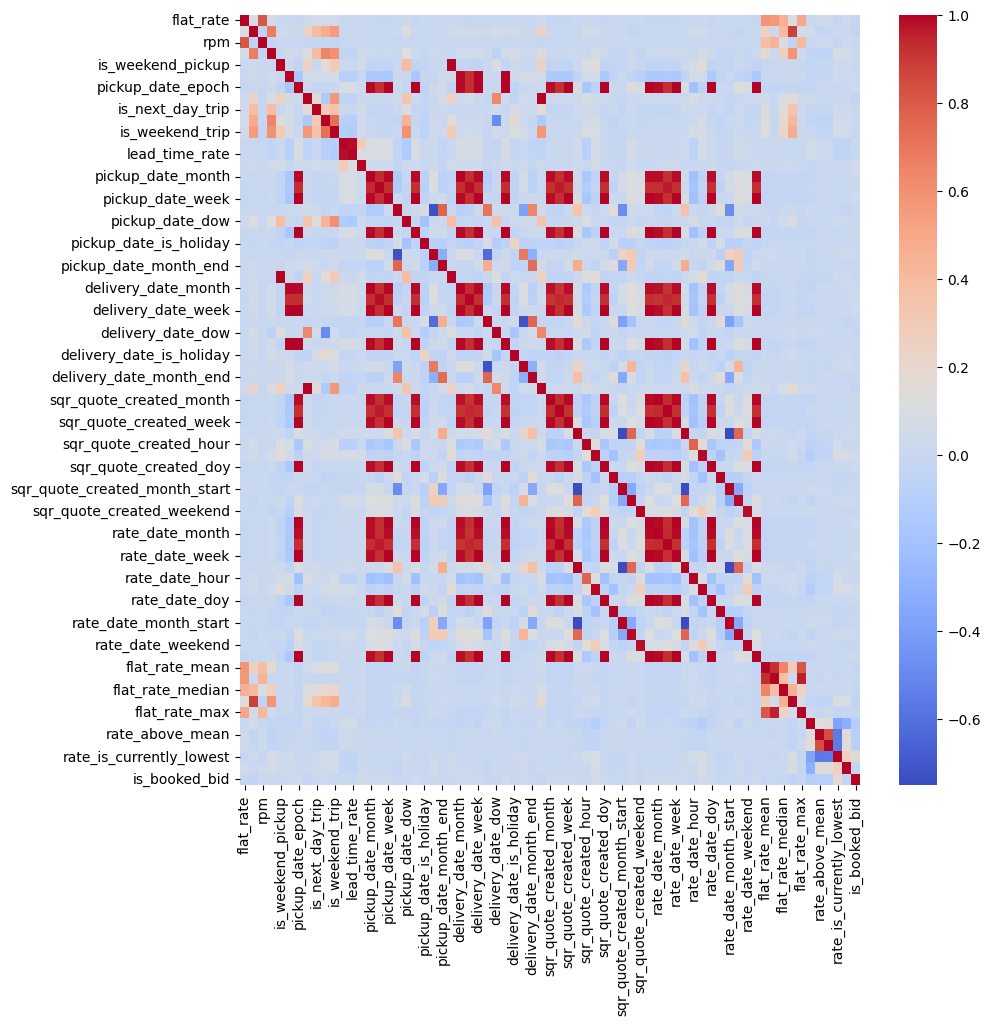

In [12]:
def plot_correlation(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(data.corr(), annot=False, ax=ax, cmap="coolwarm")
    plt.show()


plot_correlation(features)

The last line/column is the target variable.

As we can see, the target variable isn't strongly correlated to any of the variables above.


In [13]:
y = features["is_booked_bid"].copy(deep=True)

In [14]:
y.value_counts()

0    47018
1     3130
Name: is_booked_bid, dtype: int64

In [15]:
y.value_counts() / y.shape[0]

0    0.937585
1    0.062415
Name: is_booked_bid, dtype: float64

As we can see, only 6.2% of the bids are booked, meaning this is a highly unbalanced problem.


In [16]:
X = features.drop(["is_booked_bid", "sqr_quote_created"], axis=1)

In [17]:
# replace infinity for NaN in the dataframe X
import numpy as np

X = X.replace([np.inf, -np.inf], np.nan)

In [18]:
categorical_features

['quote_type',
 'equipment_type',
 'origin_zip3',
 'origin_kma',
 'origin_state',
 'origin_country',
 'dest_zip3',
 'dest_kma',
 'dest_state',
 'dest_country',
 'shipper_plan',
 'shipper_origin',
 'quoting_channel',
 'lane_type',
 'award_type',
 'origin_type',
 'load_channel']

## Building the transdformer pipeline

Below we use Sklearn's transformer pipeline to:

- Impute missing values depending on the feature type
- Scale the features using a StandardScaler, which is a requirement to use Logistic Regression.
- Treat categorical features as dummy variables using One Hot Encoding


In [19]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from utils import ConstantImputer
from sklearn.compose import make_column_transformer

SimpleImputer.get_feature_names_out = lambda self, names=None: self.feature_names_in_

numerical_transformer = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler()
)
categorical_transformer = make_pipeline(
    ConstantImputer(), OneHotEncoder(handle_unknown="ignore")
)
transformer = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features),
)

In [20]:
results = []

## Using a Dummy Classifier

This classifier will just predict the most frequent class in the training set.

We will get horrible metrics overall, but an accuracy of 67% on the validation.

This highlights why you **must** use many metrics besides accuracy when evaluating
classification, as each one has their trade-offs.


In [21]:
y.value_counts()

0    47018
1     3130
Name: is_booked_bid, dtype: int64

In [22]:
from utils import time_series_validation


regressor = DummyClassifier(strategy="stratified", random_state=42)
pipe = make_pipeline(transformer, regressor)
result = time_series_validation(X, y, base_data=features, model=pipe)

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


In [23]:
result

,fold,n_train,n_test,f1_train,recall_train,precision_train,roc_auc_train,accuracy_train,f1_validation,recall_validation,precision_validation,roc_auc_validation,accuracy_validation,true_postive_validation,false_postive_validation,true_negative_validation,false_negative_validation
0,0,30708,1750,0.047183,0.047170,0.047196,0.493902,0.888205,0.083721,0.084906,0.082569,0.512039,0.887429,0.005143,0.057143,0.882286,0.055429
1,1,32458,2072,0.047967,0.048218,0.047718,0.494060,0.887485,0.070039,0.069231,0.070866,0.504234,0.884653,0.004344,0.056950,0.880309,0.058398
2,2,34530,1912,0.048613,0.048577,0.048649,0.494497,0.887779,0.025424,0.025862,0.025000,0.480359,0.879707,0.001569,0.061192,0.878138,0.059100
3,3,36442,1840,0.048769,0.048747,0.048792,0.494523,0.887602,0.067797,0.066667,0.068966,0.501938,0.880435,0.004348,0.058696,0.876087,0.060870
4,4,38282,1615,0.048426,0.048373,0.048480,0.494207,0.887075,0.082474,0.084211,0.080808,0.512171,0.889783,0.004954,0.056347,0.884830,0.053870
5,5,39897,1714,0.048234,0.048122,0.048346,0.494163,0.887235,0.102564,0.093750,0.113208,0.517241,0.877480,0.007001,0.054842,0.870478,0.067678
6,6,41611,1977,0.050820,0.050861,0.050780,0.495083,0.885992,0.051064,0.054545,0.048000,0.495403,0.887203,0.003035,0.060192,0.884168,0.052605
7,7,43588,2042,0.051744,0.051784,0.051704,0.495683,0.886483,0.107143,0.099338,0.116279,0.519526,0.877571,0.007346,0.055828,0.870225,0.066601
8,8,45630,2354,0.053328,0.053299,0.053358,0.496234,0.885623,0.110092,0.098901,0.124138,0.520215,0.876381,0.007647,0.053951,0.868734,0.069669
9,9,47984,2164,0.053897,0.053741,0.054054,0.496179,0.884399,0.067073,0.057895,0.079710,0.496779,0.858595,0.005083,0.058688,0.853512,0.082717


In [24]:
results_dummy = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)

In [25]:
results_dummy["model"] = "Dummy"
results.append(results_dummy)

results_dummy

,metric,mean,std,50%,model
0,n_train,39113.000000,5694.129101,39089.500000,Dummy
1,n_test,1944.000000,224.646389,1944.500000,Dummy
2,f1_train,0.049898,0.002380,0.048691,Dummy
3,recall_train,0.049889,0.002349,0.048662,Dummy
4,precision_train,0.049908,0.002416,0.048720,Dummy
5,roc_auc_train,0.494853,0.000886,0.494510,Dummy
6,accuracy_train,0.886788,0.001165,0.887155,Dummy
7,f1_validation,0.076739,0.026449,0.076257,Dummy
8,recall_validation,0.073530,0.023345,0.076721,Dummy
9,precision_validation,0.080954,0.030947,0.080259,Dummy


## Using Logistic Regression

We will use the logistic regression with all features, even the uncorrelated ones.

This will give better results from compared to the previous model, with not signs of overfitting.

But because we have too many unrelated variables, the model will use L2 regularization to reduce the weights of the unrelated variables.


In [26]:
regressor = LogisticRegression(penalty="l2", n_jobs=-1, random_state=42, max_iter=1000)
pipe = make_pipeline(transformer, regressor)
result = time_series_validation(X, y, base_data=features, model=pipe)

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


##TODO: print confusion matrix as well


In [27]:
results_logit = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
results_logit["model"] = "Logistic Regression (Logit)"
results.append(results_logit)
results_logit

,metric,mean,std,50%,model
0,n_train,39113.000000,5694.129101,39089.500000,Logistic Regression (Logit)
1,n_test,1944.000000,224.646389,1944.500000,Logistic Regression (Logit)
2,f1_train,0.252453,0.021144,0.241739,Logistic Regression (Logit)
3,recall_train,0.154393,0.016600,0.146335,Logistic Regression (Logit)
4,precision_train,0.699558,0.017581,0.701475,Logistic Regression (Logit)
5,roc_auc_train,0.901974,0.006646,0.900807,Logistic Regression (Logit)
6,accuracy_train,0.945634,0.000841,0.945458,Logistic Regression (Logit)
7,f1_validation,0.211113,0.111083,0.174348,Logistic Regression (Logit)
8,recall_validation,0.141217,0.086112,0.106412,Logistic Regression (Logit)
9,precision_validation,0.498716,0.187738,0.557525,Logistic Regression (Logit)


### Top 10 features


In [28]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(10)

,features,coefficients
0,pipeline-1__flat_rate,[-6.354905842287554]
1299,pipeline-2__origin_type_missing,[-4.390930705020975]
1300,pipeline-2__origin_type_shipment,[2.232812068810801]
1301,pipeline-2__origin_type_spot_quote,[2.147334668635861]
60,pipeline-1__flat_rate_median,[2.1051661479857207]
1289,pipeline-2__shipper_plan_manage transportation,[1.8240033714755635]
59,pipeline-1__flat_rate_std,[-1.6483704056407549]
233,pipeline-2__origin_zip3_469,[-1.5812772490420537]
278,pipeline-2__origin_zip3_608,[1.5247440277095727]
1288,pipeline-2__shipper_plan_free,[-1.4606231546635673]


## Removing weak features using ANOVA

I'll just keep 20 features with the best F-value from the ANOVA, this will remove the features with weak effects on the target variable.


In [29]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=20)

pipe = make_pipeline(transformer, selector, regressor)

In [30]:
result = time_series_validation(X, y, base_data=features, model=pipe)
results_logit_sel = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
results_logit_sel["model"] = "Logit + Selection"
results.append(results_logit_sel)
results_logit_sel

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


,metric,mean,std,50%,model
0,n_train,39113.000000,5694.129101,39089.500000,Logit + Selection
1,n_test,1944.000000,224.646389,1944.500000,Logit + Selection
2,f1_train,0.018509,0.010917,0.018742,Logit + Selection
3,recall_train,0.009405,0.005591,0.009492,Logit + Selection
4,precision_train,0.672755,0.163652,0.721444,Logit + Selection
5,roc_auc_train,0.853920,0.005259,0.851556,Logit + Selection
6,accuracy_train,0.940771,0.000773,0.940956,Logit + Selection
7,f1_validation,0.032189,0.096465,0.000000,Logit + Selection
8,recall_validation,0.019729,0.059693,0.000000,Logit + Selection
9,precision_validation,0.180000,0.382390,0.000000,Logit + Selection


### Top 10 features


In [31]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(10)

,features,coefficients
16,pipeline-2__origin_type_missing,[-5.853958590256662]
15,pipeline-2__shipper_plan_manage transportation,[2.220609138258449]
5,pipeline-2__origin_zip3_467,[1.37526733436797]
13,pipeline-2__dest_country_US,[-0.8003998165348446]
14,pipeline-2__dest_country_USA,[-0.7591633272866707]
3,pipeline-1__rate_is_currently_lowest,[0.7312941251150842]
19,pipeline-2__load_channel_rfp-backend,[0.7004720065207695]
6,pipeline-2__origin_zip3_481,[-0.6671803771491885]
4,pipeline-2__origin_zip3_281,[0.539863020922465]
7,pipeline-2__origin_kma_IN_FTW,[-0.5251760513043069]


## Rebalancing the target variable

Another problem we have is that the dataset is unbalanced. We have only 6% of the rates as the lowest.

Using the parameter `class_weight="balanced"` we will give more weight to the minority
class so the dataset is 50/50


In [32]:
regressor = LogisticRegression(
    class_weight="balanced", n_jobs=-1, random_state=42, max_iter=1000
)
pipe = make_pipeline(transformer, regressor)

result = time_series_validation(X, y, base_data=features, model=pipe)
result_logit_sel_bal = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
result_logit_sel_bal["model"] = "Logit + Balancing"
results.append(result_logit_sel_bal)
result_logit_sel_bal

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


,metric,mean,std,50%,model
0,n_train,39113.000000,5694.129101,39089.500000,Logit + Balancing
1,n_test,1944.000000,224.646389,1944.500000,Logit + Balancing
2,f1_train,0.366157,0.014715,0.360827,Logit + Balancing
3,recall_train,0.904230,0.008205,0.905229,Logit + Balancing
4,precision_train,0.229625,0.011153,0.225390,Logit + Balancing
5,roc_auc_train,0.912756,0.006681,0.911267,Logit + Balancing
6,accuracy_train,0.813019,0.012141,0.809501,Logit + Balancing
7,f1_validation,0.291874,0.037663,0.290335,Logit + Balancing
8,recall_validation,0.823056,0.033104,0.833063,Logit + Balancing
9,precision_validation,0.178160,0.028191,0.175428,Logit + Balancing


Rebalancing sacrificies precision and accuracy to gain recall. The model is more likely to predict a lowest rate class, but it is also more likely to be wrong when it does so. This is a good trade-off when the cost of false negatives is high.


### Top 10 features


In [33]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(10)

,features,coefficients
0,pipeline-1__flat_rate,[-15.10774571761416]
1299,pipeline-2__origin_type_missing,[-5.811842991265459]
59,pipeline-1__flat_rate_std,[-4.091673544594812]
60,pipeline-1__flat_rate_median,[3.513073191470965]
233,pipeline-2__origin_zip3_469,[-2.932471487749118]
1301,pipeline-2__origin_type_spot_quote,[2.85536454151086]
1300,pipeline-2__origin_type_shipment,[2.833239721509936]
393,pipeline-2__origin_zip3_988,[2.762787988376045]
58,pipeline-1__flat_rate_mean,[2.528731576102802]
232,pipeline-2__origin_zip3_467,[2.4113751385862563]


## Comparing results


In [34]:
validation_results = pd.concat(results)
validation_results = validation_results.loc[
    validation_results["metric"].str.contains("_validation"),
    ["model", "metric", "mean", "50%"],
].reset_index(drop=True)

In [35]:
validation_results

,model,metric,mean,50%
0,Dummy,f1_validation,0.076739,0.076257
1,Dummy,recall_validation,0.073530,0.076721
2,Dummy,precision_validation,0.080954,0.080259
3,Dummy,roc_auc_validation,0.505991,0.508137
4,Dummy,accuracy_validation,0.879924,0.880071
5,Dummy,true_postive_validation,0.005047,0.005018
6,Dummy,false_postive_validation,0.057383,0.057046
7,Dummy,true_negative_validation,0.874877,0.877113
8,Dummy,false_negative_validation,0.062694,0.059985
9,Logistic Regression (Logit),f1_validation,0.211113,0.174348


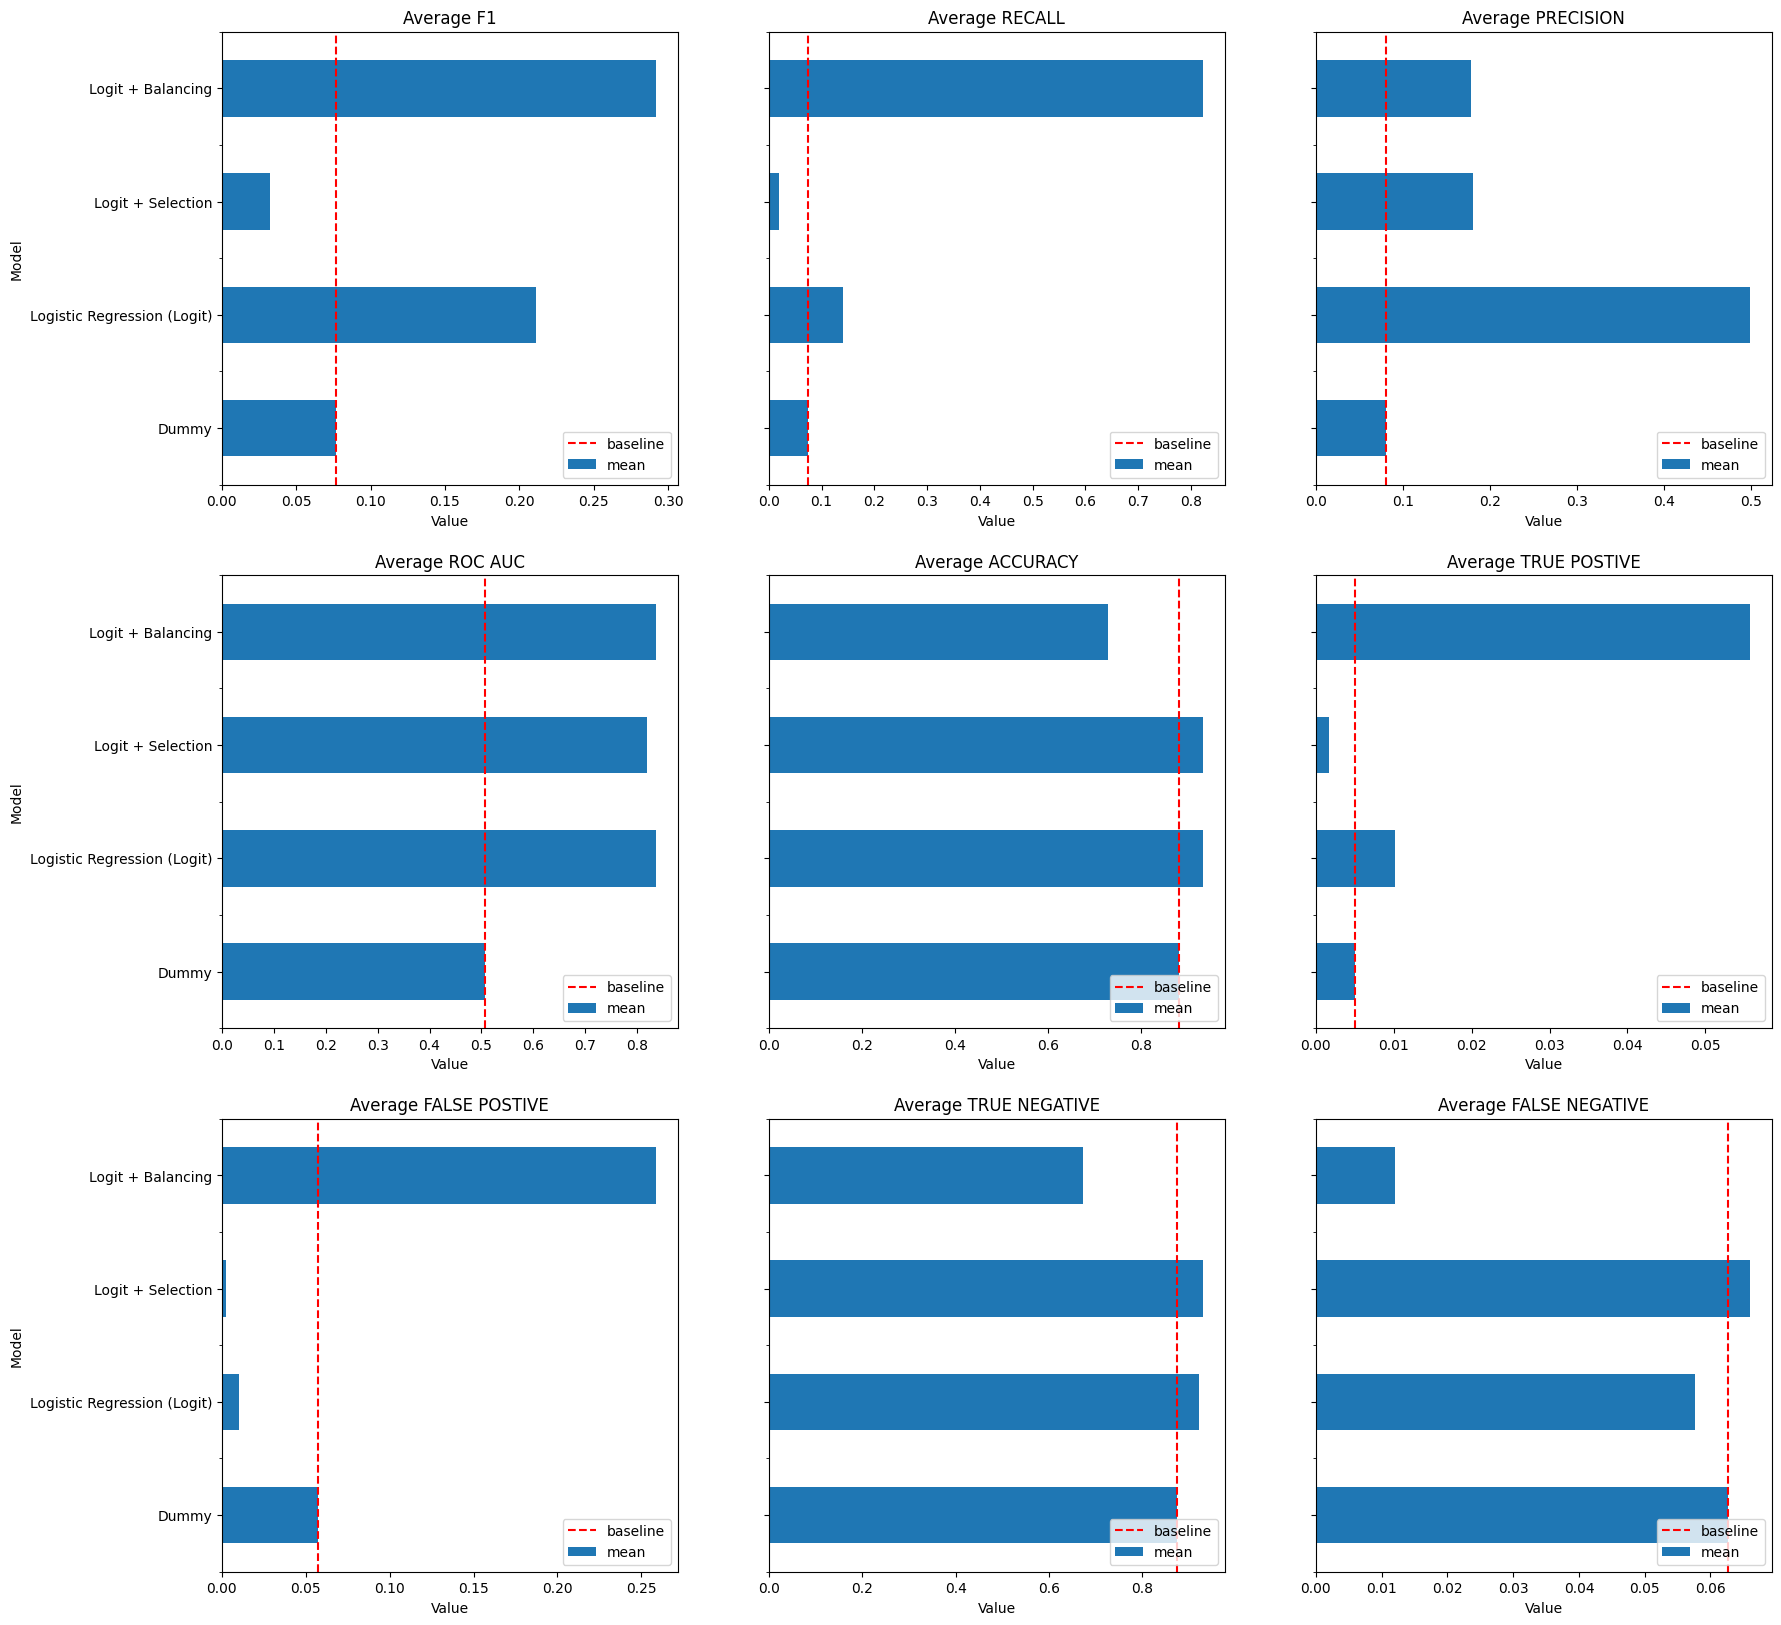

In [36]:
models = validation_results["model"].unique()
metrics = validation_results["metric"].unique()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharey=True)

for metric, ax in zip(metrics, axes.flatten()):
    baseline = validation_results.loc[
        (validation_results["metric"] == metric)
        & (validation_results["model"] == "Dummy"),
        "mean",
    ].values[0]
    ax.axvline(baseline, label="baseline", color="red", linestyle="dashed")
    validation_results[validation_results["metric"] == metric].plot.barh(
        y="mean",
        x="model",
        ax=ax,
        legend=False,
    )
    ax.set_title(
        "Average " + metric.removesuffix("_validation").replace("_", " ").upper()
    )
    ax.set_xlabel("Value")
    ax.set_ylabel("Model")
    ax.legend(loc="lower right")
    # ax.legend(loc="lower right")

The same can be said about this problem and the previous notebook. In this case though, balancing the data give better
overall results and this is most likely due to the data being extremely unbalanced.

## Next steps

Same as last one. But for this model I'd think about explaining the output of the model to the carrier might be essential.

Just giving a probability of the bid being booked is not enough. We need to explain why the bid is booked or not booked while respecting data privacy.

A simple: "This bid is too low/high compared to similar bids" might be enough to nudge the carrier in the right direction.
